In [63]:
import numpy as np
import matplotlib.pyplot as plt
import stan
import pandas as pd
import arviz as az
import seaborn as sns
import nest_asyncio
nest_asyncio.apply()

### Load data and implement model

In [56]:
program_code = """
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    // Your code here
    real<lower=0> v1; // Drift rates
    real<lower=0> v2;
    real<lower=0> a; // Decision threshold
    real<lower=0, upper=1> beta; // Bias
    real<lower=0> tau; // Non-decision time
}

model {
    // Priors
    // Your code here
    v1 ~ gamma(3,1);
    v2 ~ gamma(3,1);
    a ~ gamma(3,1);
    beta ~ gamma(2,2);
    tau ~ gamma(2,1);

    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                 // Your code here
                 y[n] ~ wiener(a, tau, beta, v1);
            }
            else {
                 // Your code here
                 y[n] ~ wiener(a, tau, 1-beta, 1-v1);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                // Your code here
                y[n] ~ wiener(a, tau, beta, v2);
            }
            else {
                 // Your code here
                 y[n] ~ wiener(a, tau, 1-beta, 1-v2);
            }
        }
    }
}

"""

In [57]:
samples = pd.read_csv("sample_response_times.csv", delimiter=';')
rt = samples["rt"].to_list()
choice = samples["choice"].astype(int).to_list()
cond = samples["condition"].astype(int).to_list()

data = {
    'N' : len(samples),
    'y' : rt,
    'condition' : cond,
    'choice' : choice
}

model = stan.build(program_code=program_code, data=data)

Building...



Building: found in cache, done.

### Fit and diagnose model

In [58]:
# Fit model
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=3000)

Sampling:   0%
Sampling:   0% (1/16000)
Sampling:   0% (2/16000)
Sampling:   0% (3/16000)
Sampling:   0% (4/16000)
Sampling:   1% (103/16000)
Sampling:   1% (202/16000)
Sampling:   2% (301/16000)
Sampling:   2% (400/16000)
Sampling:   3% (500/16000)
Sampling:   4% (600/16000)
Sampling:   4% (700/16000)
Sampling:   5% (800/16000)
Sampling:   6% (900/16000)
Sampling:   6% (1000/16000)
Sampling:   7% (1100/16000)
Sampling:   8% (1200/16000)
Sampling:   8% (1300/16000)
Sampling:   9% (1400/16000)
Sampling:   9% (1500/16000)
Sampling:  10% (1600/16000)
Sampling:  11% (1700/16000)
Sampling:  11% (1800/16000)
Sampling:  12% (1900/16000)
Sampling:  12% (2000/16000)
Sampling:  13% (2100/16000)
Sampling:  14% (2200/16000)
Sampling:  14% (2300/16000)
Sampling:  15% (2400/16000)
Sampling:  16% (2500/16000)
Sampling:  16% (2600/16000)
Sampling:  17% (2700/16000)
Sampling:  18% (2800/16000)
Sampling:  18% (2900/16000)
Sampling:  19% (3000/16000)
Sampling:  19% (3100/16000)
Sampling:  20% (3200/16000

In [59]:
# Extract samples and show summary stats
df = fit.to_frame()
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v1,2.765,0.259,2.273,3.247,0.003,0.002,8032.0,7186.0,1.0
v2,0.776,0.204,0.395,1.168,0.002,0.002,6983.0,5791.0,1.0
a,0.884,0.029,0.831,0.938,0.000,0.000,7619.0,7911.0,1.0
beta,0.516,0.021,0.477,0.556,0.000,0.000,6303.0,7314.0,1.0
tau,0.395,0.003,0.389,0.401,0.000,0.000,7058.0,7935.0,1.0


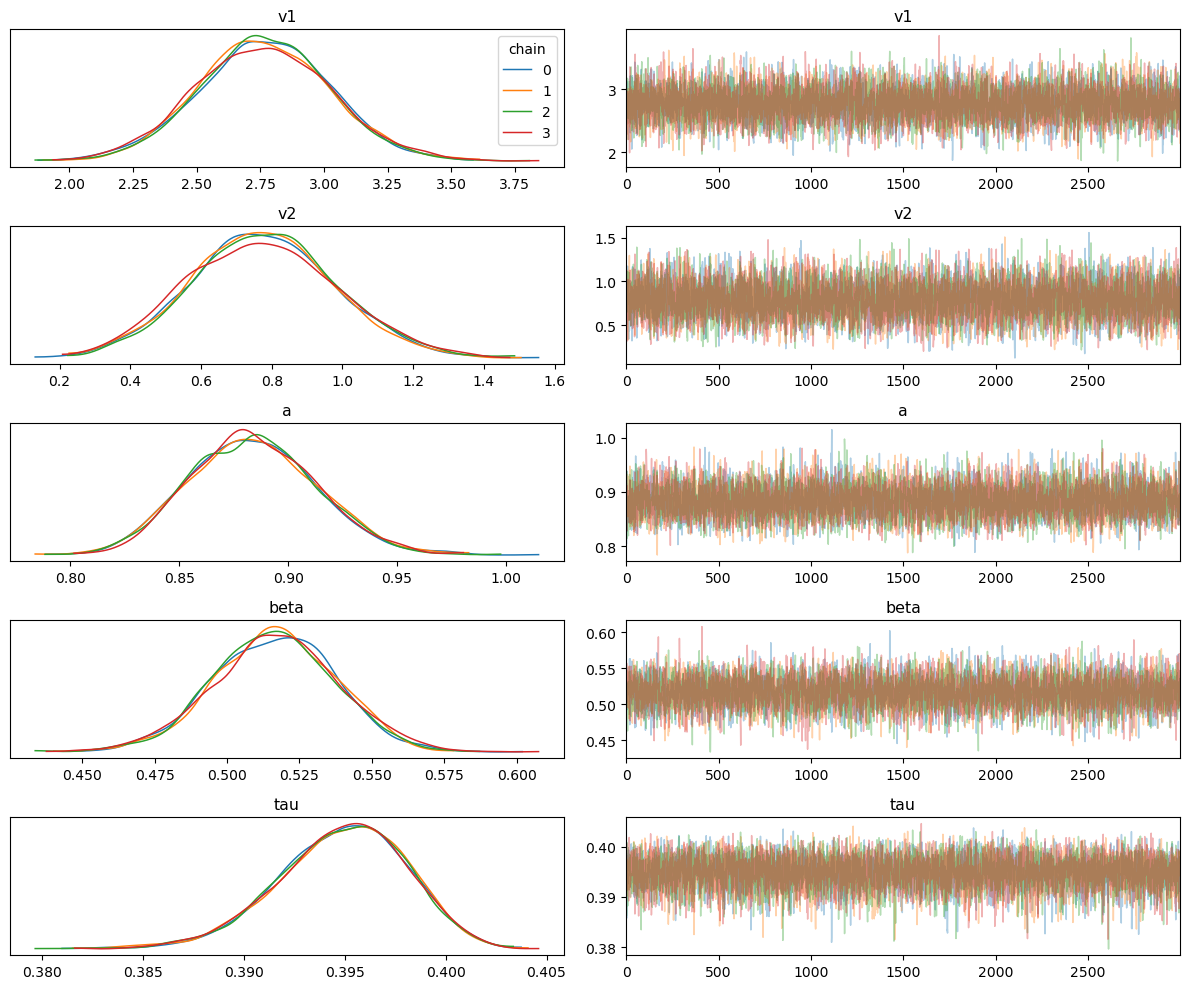

In [60]:
# Diagnose parameters
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

2.7652165092858922
0.7762533386037342


/home/chase/miniconda3/envs/cog/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chase/miniconda3/envs/cog/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


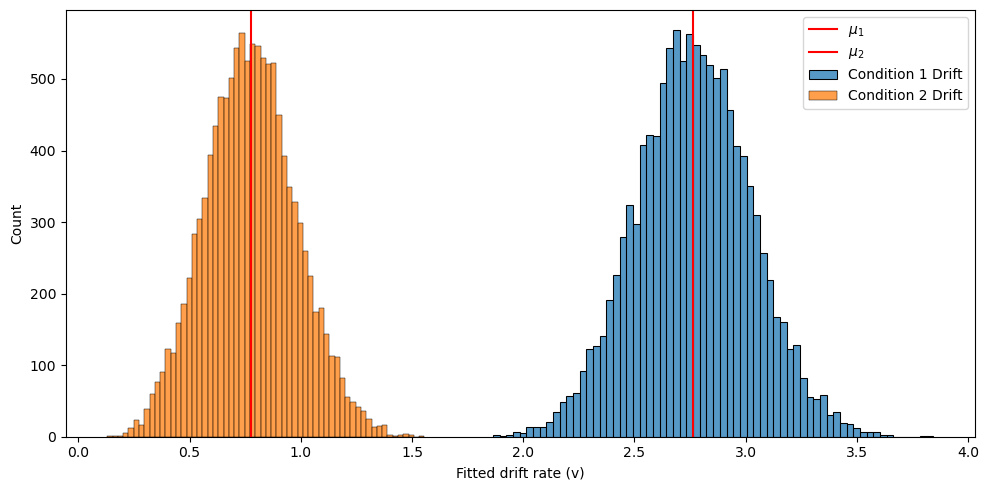

In [71]:
# Inspect drift rates
mu1 = np.mean(df.v1)
mu2 = np.mean(df.v2)
print(mu1)
print(mu2)
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.histplot(df.v1, ax=ax, label="Condition 1 Drift")
sns.histplot(df.v2, ax=ax, label="Condition 2 Drift")
ax.axvline(np.mean(df.v1), label=r"$\mu_1$", color="red")
ax.axvline(np.mean(df.v2), label=r"$\mu_2$", color="red")
ax.legend()
ax.set(xlabel="Fitted drift rate (v)")
f.tight_layout()

### Determine unknown condition indicator
By fitting a drift rate to each condition, we are able to identify the unknown condition indicators. Usually, a lower drift rate indicates a more difficult task provided lower evidence accumulation and longer reaction times. Observing the above result, we can see that condition 1 has a drift rate centered around 2.75 and condition 2 has a drift rate centered around 0.75. Thus, condition 1 is the 10-selection task and condition 2 is the 100-selection task.